In [2]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
local_path = os.path.abspath('')
sys.path.append(local_path)
import numpy as np
import plotly.graph_objects as go

In [3]:
from functions import plotgenerator as pg
import utils, model, egm, simulations, estimation 

In [5]:
# read txt file in the data folder
#filename = "data/income.txt" # placed in the current folder at this point
#income = np.loadtxt(filename,delimiter=",")

# polynomial fit
#x = np.arange(25,65)
#y = np.log(income)

#degree = 6
#coeffs = np.polyfit(x,y,degree)
#print(coeffs)

FileNotFoundError: data/income.txt not found.

# Solution to the model

In [6]:
# Setup
par_init_sol = model.gp_model()

### plotting Income shifter

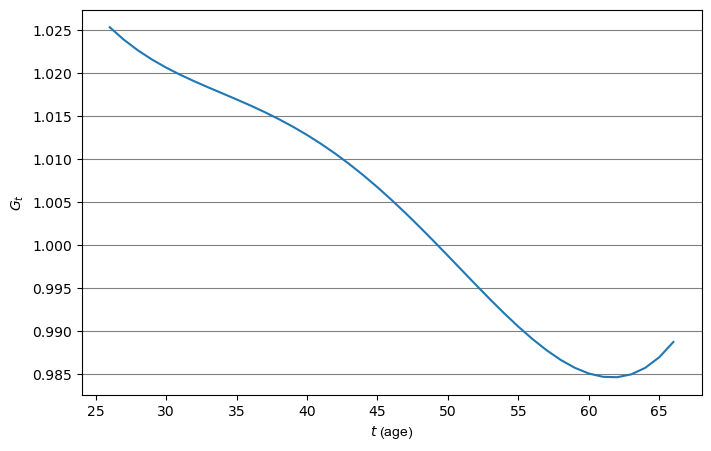

In [8]:
# Print consumption function (THOMAS G_T FUNCTION)
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(range(par_init_sol.par.t0,par_init_sol.par.Tr+1),par_init_sol.par.G, label=f"Income shifter", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$ (age)")
# fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
# fig.save_figure(f'{local_path}/output/income_shifter.png')
# fig.add_legend()
fig.show()

### solving the model

In [9]:
# Solve the model
solObj = egm.solver(par_init_sol.par)
solObj.solve(do_print=False)
sol = solObj.sol


### plotting the results

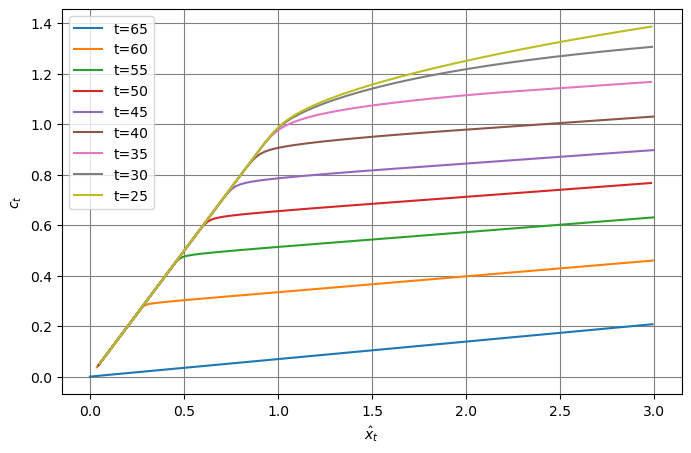

In [10]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
for t in range(par_init_sol.par.Tr_N-1,par_init_sol.par.t0_N-1,-5):
    criteria = np.where(sol.m[:,t] <= 3, True, False)
    fig.add_plot(sol.m[criteria,t],sol.c[criteria,t], label=f"t={25+t}", linestyle='-')
fig.set_ylabel(f"$c_t$")
fig.set_xlabel("$\hat{x}_t$")
# fig.set_title(f'Value function solved with EGM')
fig.add_gridlines(axis='both')
fig.add_legend()
#fig.save_figure(f'{local_path}/output/egm_consumption.png')
fig.show()

### simulate how results look like

In [11]:
sim = simulations.Simulator(par_init_sol.par, sol).sim

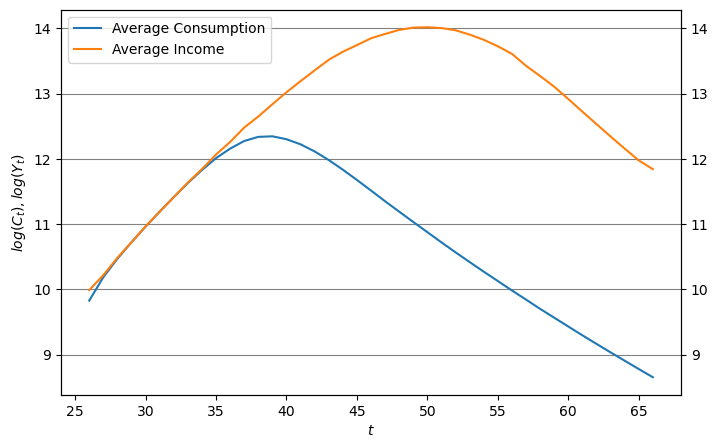

In [12]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
# fig.add_plot(x,(sim.Y_avg-sim.C_avg), label=f"Average Savings", linestyle='--',color='black',axis='y2')
# fig.set_ylabel(f"$log(Savings)$",axis='y2')
fig._set_scaling()
fig.set_ylabel(f"$log(C_t), log(Y_t)$")
fig.set_xlabel(f"$t$")
fig.add_gridlines(axis='y')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/simulation_of_solution.png')
fig.show()

##### Decompose savings 

In [13]:
model_lc = model.gp_model(**{'sigma_eta': 0.0, 'sigma_mu':0.0,'pi':0,'xmin':-10.0})

# retirement rule
NT = 88-65
beta = 1.0/(1.0344) # estimated in GP
beta_rho = beta**(1.0/model_lc.par.rho)
R_rho = (1+model_lc.par.R)**(1.0/model_lc.par.rho - 1.0)
nom = 1.0 - beta_rho*R_rho
denom = 1.0 - (beta_rho*R_rho)**NT
model_lc.gamma1 = nom/denom
model_lc.main_setup()

# Solve the Life-cycle model
sol_lc = egm.solver(model_lc.par)
sol_lc.solve(do_print=False)
sol_lc = sol_lc.sol

# Simulate the Life-cycle model
sim_lc = simulations.Simulator(model_lc.par, sol_lc).sim

In [14]:
# Decomposition
S_lc = np.mean(sim_lc.S[1:],axis=1)
S = np.mean(sim.S[1:],axis=1)
S_b  = S - S_lc 

# S is the same as calculation below
print(np.mean(sim.a[1:,:]*sim.P[1:,:] - sim.a[:-1,:]*sim.P[:-1,:],axis=1)[:])

[0.07030516 0.04275577 0.03108448 0.02606729 0.02484192 0.02481291
 0.03022439 0.04522954 0.0731815  0.11847217 0.21951314 0.34931434
 0.53138739 0.76698367 1.04816985 1.34650342 1.66693048 1.99816878
 2.31680681 2.6547418  2.9737192  3.29409689 3.59853565 3.88220209
 4.15611887 4.41534842 4.64799168 4.87165691 5.08027518 5.28030518
 5.41987182 5.58771147 5.7503195  5.89286443 6.03336014 6.17939271
 6.33034372 6.48893084 6.65736402 6.87477284]


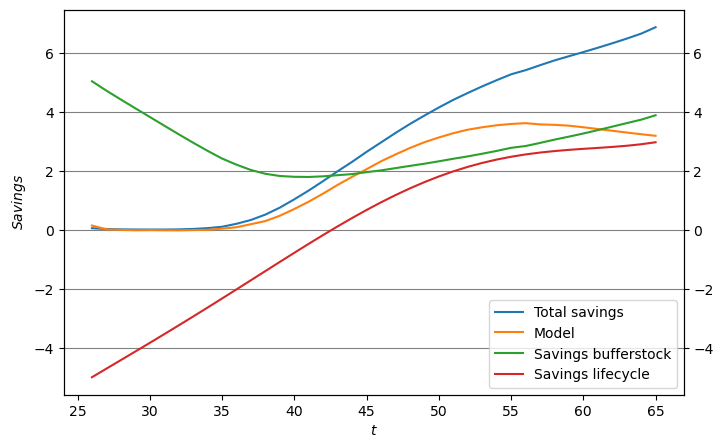

In [16]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(0+par_init_sol.par.t0,len(S)+par_init_sol.par.t0)
fig.add_plot(x,S, label=f"Total savings", linestyle='-',axis='y1')
fig.add_plot(x,(sim.Y_avg-sim.C_avg)[:-1], label=f"Model", linestyle='-',axis='y1')
fig.add_plot(x,S_b, label=f"Savings bufferstock", linestyle='-',axis='y1')
fig.add_plot(x,S_lc, label=f"Savings lifecycle", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$Savings$")
fig.set_xlabel(f"$t$")
fig.add_gridlines(axis='y')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/savings_decomposition.png')
fig.show()
#

# Estimation based on random data

### Data generation

In [17]:
# Setup params
par_dgp = model.gp_model().par
par_dgp.beta = 0.95
par_dgp.rho = 0.45
sol_dgp = egm.solver(par_dgp)
sol_dgp.solve(do_print=False)

dgp_par = [par_dgp.beta, par_dgp.rho]
# 
# sim_dgp = simulations.sim_setup(par_dgp)
# simulations.draw_random(par_dgp, sim_dgp)
# sim_dgp = simulations.simulate(sim_dgp, par_dgp, sol_dgp.sol)
sim_dgp = simulations.Simulator(par_dgp, sol_dgp.sol).sim

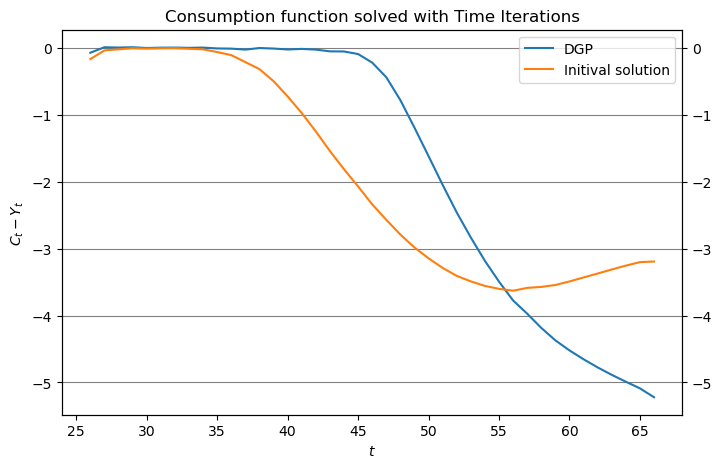

In [18]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
y1 = sim_dgp.C_avg - sim_dgp.Y_avg
y2 = sim.C_avg - sim.Y_avg
fig.add_plot(x,y1, label=f"DGP", linestyle='-',axis='y1')
fig.add_plot(x,y2, label=f"Initival solution", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t - Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

In [19]:
weight_mat_inv = np.eye(sim_dgp.C_avg.size)   # The identity matrix and I^-1=I
est = estimation.SMD(model=par_dgp,solver=egm.solver, simulator=simulations.Simulator, mom_data=sim_dgp.C_avg)

### grid search

In [20]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

### estimation

In [21]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
print(f'estimated values using grid method {est.est} and true parameters {dgp_par}')

In [22]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

[[-2.07686410e+09  5.67249980e+10]
 [ 5.67249980e+10 -1.54931919e+12]]


### plot the objective function for different values

In [23]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()

# Estimation using data from BLS

In [24]:
cat = ['Under 25 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65 years and older']
data = [46359, 67883, 86049, 91074, 78079, 57818]
for i in range(6):
    print(f"{cat[i]}: {data[i]:,.1f}")

Under 25 years: 46,359.0
25-34 years: 67,883.0
35-44 years: 86,049.0
45-54 years: 91,074.0
55-64 years: 78,079.0
65 years and older: 57,818.0


[56477.36226614 58912.50734658 61324.57893206 63705.04455333
 66045.37174115 68337.02802629 70571.48093949 72740.19801151
 74834.64677312 76846.29475506 78766.6094881  80587.05850299
 82299.10933049 83894.22950136 85363.88654635 86699.54799622
 87892.68138172 88934.75423363 89817.23408268 90531.58845964
 91069.28489527 91421.79092032 91580.57406555 91537.10186171
 91282.84183957 90809.82614274 90123.07301059 89240.58677821
 88180.93639359 86962.6908047  85604.41895949 84124.68980595
 82542.07229205 80875.13536574 79142.44797501 77362.57906782
 75554.09759214 73735.57249594 71925.5727272  70142.66723387
 68405.42496394]


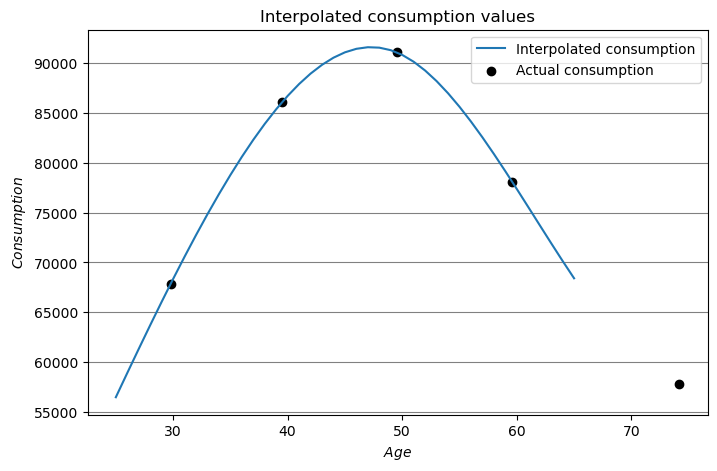

In [26]:
from scipy.interpolate import interp1d
age_groups = [29.8,39.5,49.5,59.6,74.2] #[25, 35, 45, 55, 65]
consumptions = data[1:]
# Create the interpolation function
interp_function = interp1d(age_groups, consumptions, kind='cubic', fill_value="extrapolate")

# Generate the ages for which we want to interpolate
ages = np.arange(25, 66)
# Interpolate the consumption values for these ages
interpolated_consumptions = interp_function(ages)
print(interpolated_consumptions)

# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(ages, interpolated_consumptions, label=f"Interpolated consumption", linestyle='-')
fig.add_plot(age_groups[0], data[1], label=f"Actual consumption", color='black',marker='o')
fig.add_plot(age_groups[1], data[2], color='black',marker='o')
fig.add_plot(age_groups[2], data[3], color='black',marker='o')
fig.add_plot(age_groups[3], data[4], color='black',marker='o')
fig.add_plot(age_groups[4], data[5], color='black',marker='o')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.set_title(f'Interpolated consumption values')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

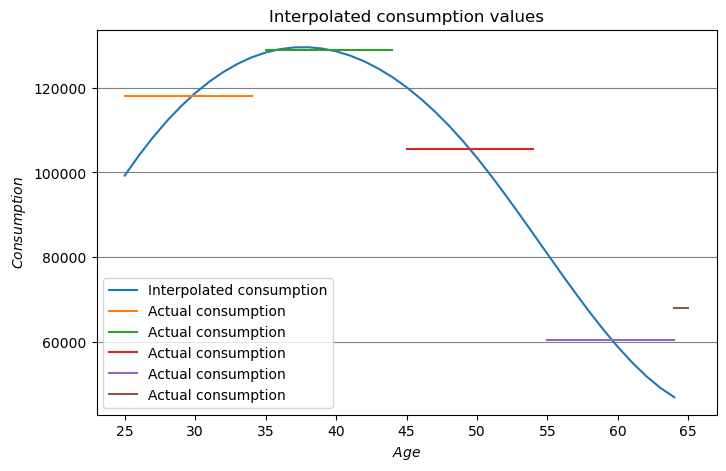

In [31]:
#age_groups = [29.8, 39.5, 49.5, 59.6, 69.3]

y_before_tax = [89514, 118149, 128980, 105498, 60359, 68059]

income = y_before_tax[1:]
#print(y_before_tax)
# Create the interpolation function
interp_function = interp1d(age_groups, income, kind='cubic', fill_value="extrapolate")

# Generate the ages for which we want to interpolate
ages = np.arange(25, 65)
# Interpolate the consumption values for these ages
interpolated_income = interp_function(ages)
#print(interpolated_income)

# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(ages, interpolated_income, label=f"Interpolated consumption", linestyle='-')
fig.add_plot(np.arange(25,35), np.repeat(income[0],np.arange(25,35).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(35,45), np.repeat(income[1],np.arange(35,45).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(45,55), np.repeat(income[2],np.arange(35,45).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(55,65), np.repeat(income[3],np.arange(35,45).shape[0]), label=f"Actual consumption", linestyle='-')
fig.add_plot(np.arange(64,66), np.repeat(income[4],np.arange(44,46).shape[0]), label=f"Actual consumption", linestyle='-')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.set_title(f'Interpolated consumption values')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

[1.0281439127836913, 1.008809660024172, 0.9801040535920403, 0.9456921432247083, 1.0120788582028273]


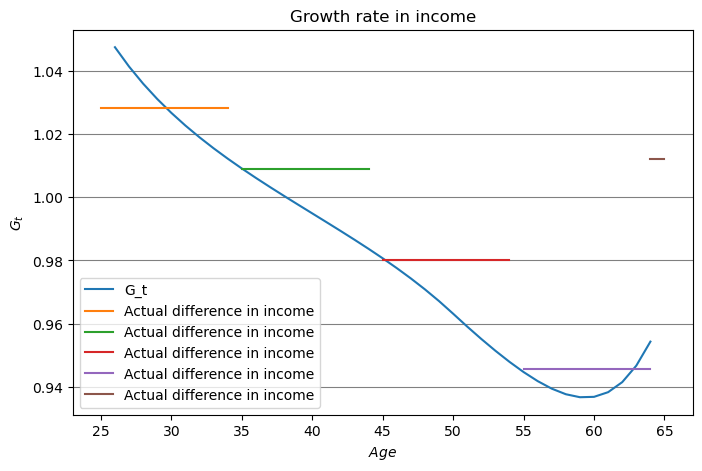

In [39]:
#log_income = np.log(interpolated_income)
#log_income = np.exp(log_income)
g_t= interpolated_income[1:(par_init_sol.par.Tr_N+1)]/interpolated_income[0:(par_init_sol.par.Tr_N-2)]

# Calculate the difference between consecutive elements
income_array = np.array(y_before_tax)

# Calculate the percentage differences
years_interval = 10

# Calculate the percentage differences for a 15-year interval
# We calculate the compounded annual growth rate (CAGR)
pct_diffs = ((income_array[1:] / income_array[:-1]) ** (1 / years_interval) - 1)+1

# Convert to a list for readability
pct_diffs_list = pct_diffs.tolist()

print(pct_diffs_list)

time = np.arange(26, 65)
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(time, g_t, label=f"G_t", linestyle='-')
fig.add_plot(np.arange(25,35), np.repeat(pct_diffs_list[0],np.arange(25,35).shape[0]), label=f"Actual difference in income", linestyle='-')
fig.add_plot(np.arange(35,45), np.repeat(pct_diffs_list[1],np.arange(35,45).shape[0]), label=f"Actual difference in income", linestyle='-')
fig.add_plot(np.arange(45,55), np.repeat(pct_diffs_list[2],np.arange(35,45).shape[0]), label=f"Actual difference in income", linestyle='-')
fig.add_plot(np.arange(55,65), np.repeat(pct_diffs_list[3],np.arange(35,45).shape[0]), label=f"Actual difference in income", linestyle='-')
fig.add_plot(np.arange(64,66), np.repeat(pct_diffs_list[4],np.arange(44,46).shape[0]), label=f"Actual difference in income", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$Age$")
fig.set_title(f'Growth rate in income')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

In [72]:
# Setup
par_real = model.gp_model(**{'init_P':12}).par
# solve model
solObj = egm.solver(par_real)
solObj.solve()
sol_real = solObj.sol

real_par = [par_real.beta, par_real.rho]
# 
sim_real = simulations.Simulator(par_real, sol_real).sim

In [73]:
est.sim.C_avg
for i in range(0,len(est.sim.C_avg),10):
    print(f'{i+25}-{i+25+10}', est.sim.C_avg[i:i+10].mean())

25-35 11.015172590385115
35-45 12.942601567404443
45-55 11.55728257360201
55-65 8.586674630290275
65-75 7.246885788416794


In [74]:
real_data = np.array([67883, 86049, 91074, 78079])
real_data = np.log(interpolated_consumptions)
print(real_data,'\n',len(real_data))

[10.94159517 10.9838087  11.023936   11.06201903 11.09809724 11.13220704
 11.16438139 11.19464944 11.22303625 11.24956253 11.27424445 11.29709335
 11.31811556 11.33731211 11.35467842 11.37020395 11.38387182 11.39565828
 11.40553215 11.41345411 11.41937587 11.42323914 11.42497445 11.42449965
 11.42171812 11.41652278 11.40893149 11.39909122 11.38714608 11.37323446
 11.35749218 11.34005538 11.32106341 11.30066171 11.27900465 11.25625847
 11.2326042  11.20824063 11.18338715 11.15828655 11.13320741] 
 41


In [75]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = estimation.SMD(model=par_real,solver=egm.solver, simulator=simulations.Simulator, mom_data=real_data)
est_real.age_groups = False

In [76]:
est_real.beta_grid = np.arange(0.75,0.85,0.01)
est_real.rho_grid = np.arange(0.01,0.99,0.05)
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv,grid=True)

KeyboardInterrupt: 

In [77]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=[(0.01,1.05),(0.01,0.99)],W=weight_mat_inv,grid=False)

In [80]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est} with objective function value {est_real.est_out.fun}')

True
estimated values [0.96711186 0.01      ] with objective function value 101.86329048897431


In [41]:
if hasattr(est_real,'grid'):
  from plotly.subplots import make_subplots

  fig = make_subplots(
      rows=1, 
      cols=2,
      start_cell="top-left", 
      specs=[
          [{"type": "surface"}, {"type": "scattergl"}], 
      ]
  )
  fig.update_layout(paper_bgcolor="rgba(0,0,0,0)",plot_bgcolor="grey",font=dict(family="Arial",size=12,color="white"))
  # Sample data
  x, y = np.meshgrid(est_real.beta_grid, est_real.rho_grid)
  z = est_real.grid

  # Create the surface plot
  # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.add_trace(go.Surface(z=z, x=x, y=y, #coloraxis=dict(coloraxis=1),
                           ),row=1,col=1)

  # Update axes titles for the mesh plot
  fig.update_scenes(
      xaxis_title='Beta',
      yaxis_title='Rho',
      zaxis_title='Objective function',
      row=1, col=1
  )
  fig.update_scenes(aspectratio=dict(x=1, y=1, z=0.7),
                     row=1, col=1)

  fig.update_layout(title='Objective function', autosize=False,width=1000, height=500,margin=dict(l=65, r=50, b=65, t=90))
  # set the background color
  y = est_real.grid[3,:]
  x = est_real.rho_grid

  # fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y, mode='lines', ),row=1,col=2)
  # Update axes titles for each subplot
  fig.update_xaxes(title_text=f'rho', row=1, col=2)
  fig.update_yaxes(title_text='Objective function', 
                   row=1, col=2)

  fig.show()
else:
  print('No grid found')

In [83]:
# Setup
rho_opt = est_real.est[1]
beta_opt = est_real.est[0]
print(f'Optimal beta: {beta_opt}, Optimal rho: {rho_opt}')
par_fit = model.gp_model(**{'beta':beta_opt,'rho':rho_opt,'init_P':12}).par
# solve model
solObjfit = egm.solver(par_fit)
solObjfit.solve()
sol_fit = solObjfit.sol

# 
sim_fit = simulations.Simulator(par_fit, sol_fit).sim

Optimal beta: 0.9671118581706954, Optimal rho: 0.01


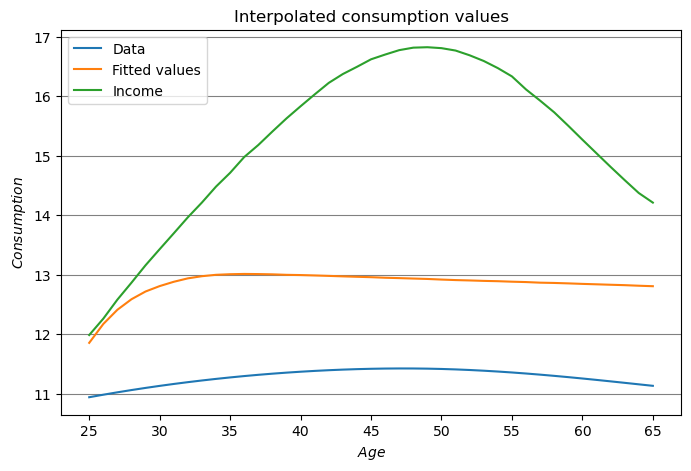

In [84]:
# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(ages, np.log(interpolated_consumptions), label=f"Data", linestyle='-')
fig.add_plot(ages, (sim_fit.C_avg), label=f"Fitted values", linestyle='-')
fig.add_plot(ages, (sim_fit.Y_avg), label=f"Income", linestyle='-')
# fig.add_plot(age_groups[0], data[1], label=f"Actual consumption", color='black',marker='o')
# fig.add_plot(age_groups[1], data[2], color='black',marker='o')
# fig.add_plot(age_groups[2], data[3], color='black',marker='o')
# fig.add_plot(age_groups[3], data[4], color='black',marker='o')
# fig.add_plot(age_groups[4], data[5], color='black',marker='o')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.set_title(f'Interpolated consumption values')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

# Extension
Imagine two types of households with different timepreference, $\beta$

#### Type I

In [ ]:
# Setup params
par_type1 = model.gp_model().par
par_type1.beta = 0.99
sol_type1 = egm.solver(par_type1)
sol_type1.solve()
sol_type1 = sol_type1.sol

type1_par = [par_type1.beta, par_type1.rho]
# 
sim_type1 = simulations.Simulator(par_type1, sol_type1).sim

#### Type II

In [ ]:
# Setup params
par_type2 = model.gp_model().par
par_type2.beta = 0.90
sol_type2 = egm.solver(par_type2)
sol_type2.solve()
sol_type2 = sol_type2.sol

type2_par = [par_type2.beta, par_type2.rho]

sim_type2 = simulations.Simulator(par_type2, sol_type2).sim

#### Aggregate consumption
Denoting the share of type I households as $\lambda$, the aggregate consumption is given by:
$$
C^{agg}_t = \lambda C^I_t + (1-\lambda) C^{II}_t
$$

In [ ]:
lambda1 = 0.4
lambda2 = 1 - lambda1
agg_model = model.gp_model().par
agg_cons = lambda1*sim_type1.C_avg + lambda2 * sim_type2.C_avg

In [ ]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,agg_cons, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_type1.C_avg, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_type2.C_avg, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [ ]:
weight_mat_inv = np.eye(agg_cons.shape[0])   # The identity matrix and I^-1=I
est_ext = estimation.SMD(model=agg_model,solver=egm.solver, simulator=simulations.Simulator, mom_data=agg_cons)

In [ ]:
est_ext.beta_grid = np.arange(0.9,0.99,0.01)
est_ext.rho_grid = np.arange(0.4,0.5,0.01)
est_ext.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

In [ ]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est_ext.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()
print(f'estimated values using grid method {est_ext.est} ')

In [ ]:
est_ext.estimate(theta0=[0.97,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

In [ ]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {est_ext.est}')
else:
    print(f'optimization failed')